# NAVER 영화 리뷰 데이터 분석

In [2]:
# 데이터 출처 : https://github.com/e9t/nsmc

# 데이터 파일
# ratings.txt       : 전체 리뷰를 모아둔 20만개의 데이터
# ratings_train.txt : 15만개의 학습 데이터
# ratings_test.txt  : 5만개의 평가 데이터

In [27]:
# 필요한 모듈을 불러옴
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
import os
import json

import seaborn as sns
from wordcloud import WordCloud

from konlpy.tag import Okt
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer

%matplotlib inline

## 데이터 분석 (EDA)

In [4]:
# 데이터의 크기를 확인
DATA_PATH = './data/'

print("파일 크기 :")
for file in os.listdir(DATA_PATH):
    if 'txt' in file:
        print(file.ljust(30) + str(round(os.path.getsize(DATA_PATH + file) / 1000000, 2)) + 'MB')

파일 크기 :
ratings_test.txt              4.89MB
ratings.txt                   19.52MB
ratings_train.txt             14.63MB


In [5]:
# 학습 데이터 확인
train_data = pd.read_csv(DATA_PATH + 'ratings_train.txt',
                         header=0, delimiter='\t', quoting=3)

print('전체 학습 데이터의 개수: {}'.format(len(train_data))) 
train_data.head()

전체 학습 데이터의 개수: 150000


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [6]:
# 학습 데이터의 리뷰 길이
train_length = train_data['document'].astype(str).apply(len)
train_length.head() 

0    19
1    33
2    17
3    29
4    61
Name: document, dtype: int64

Text(0, 0.5, 'Number of review')

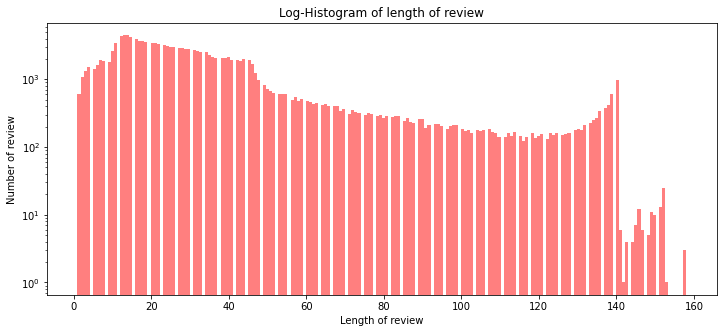

In [7]:
# 전체 데이터에 대해, 길이에 대한 히스토그램을 그림
# 그래프에 대한 이미지 크기 선언
plt.figure(figsize=(12, 5))
# 히스토그램 선언
plt.hist(train_length, bins=200, alpha=0.5, color='r', label='word')
plt.yscale('log', nonposy='clip')
# 그래프 제목
plt.title('Log-Histogram of length of review')
# 그래프 x, y축 라벨
plt.xlabel('Length of review')
plt.ylabel('Number of review')

리뷰 길이 최댓값: 158
리뷰 길이 최솟값: 1
리뷰 길이 평균값: 35.24
리뷰 길이 표준편차: 29.58
리뷰 길이 중간값: 27.0
리뷰길이 제1사분위: 16.0
리뷰길이 제3사분위: 42.0


{'whiskers': [<matplotlib.lines.Line2D at 0x7ff91b285940>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff91b501430>,
 'boxes': [<matplotlib.lines.Line2D at 0x7ff91b057af0>],
 'medians': [<matplotlib.lines.Line2D at 0x7ff91b501b20>],
 'fliers': [<matplotlib.lines.Line2D at 0x7ff91b504fa0>],
 'means': [<matplotlib.lines.Line2D at 0x7ff91b5042b0>]}

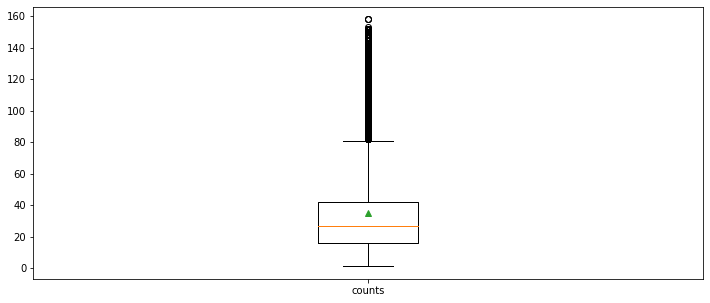

In [8]:
# 리뷰 길이 통곗값 및 박스 플롯
print('리뷰 길이 최댓값: {}'.format(np.max(train_length)))
print('리뷰 길이 최솟값: {}'.format(np.min(train_length)))
print('리뷰 길이 평균값: {:.2f}'.format(np.mean(train_length)))
print('리뷰 길이 표준편차: {:.2f}'.format(np.std(train_length)))
print('리뷰 길이 중간값: {}'.format(np.median(train_length)))
print('리뷰길이 제1사분위: {}'.format(np.percentile(train_length, 25)))
print('리뷰길이 제3사분위: {}'.format(np.percentile(train_length, 75)))

plt.figure(figsize=(12, 5))
plt.boxplot(train_length, labels=['counts'], showmeans=True)

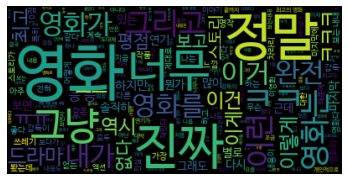

In [9]:
# 어휘 빈도 분석
# 먼저, 문자열이 아닌 다른 형식이 있다면 제거
train_review = [review for review in train_data['document'] if type(review) is str]

# wordcloud에 적용해서 그래프를 그림
# 한글 텍스트는 글자가 깨진 형태로 나오기 때문에, DATA_PATH에 한글 폰트를 넣어 설정
wordcloud = WordCloud(font_path = DATA_PATH + 'NanumBarunGothic.ttf').generate(' '.join(train_review))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

긍정 리뷰 개수: 74827
부정 리뷰 개수: 75173


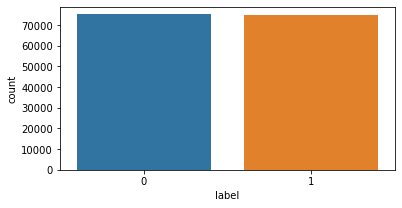

In [10]:
# 긍정, 부정 리뷰 개수와 비율을 그래프로 그림
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(6, 3)
sns.countplot(train_data['label'])

print('긍정 리뷰 개수: {}'.format(train_data['label'].value_counts()[1]))
print('부정 리뷰 개수: {}'.format(train_data['label'].value_counts()[0]))

Text(0, 0.5, 'Numver of reviews')

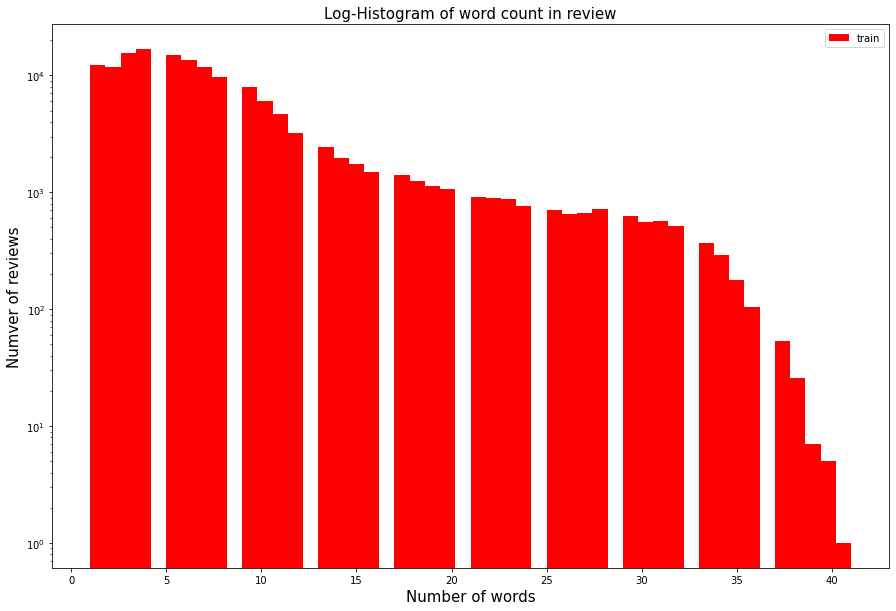

In [11]:
# 각 리뷰의 단어 개수를 히스토그램으로 그림
train_word_counts = train_data['document'].astype(str).apply(lambda x: len(x.split(' ')))

plt.figure(figsize=(15, 10))
plt.hist(train_word_counts, bins=50, facecolor='r', label='train')
plt.title('Log-Histogram of word count in review', fontsize=15)
plt.yscale('log', nonposy='clip')
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Numver of reviews', fontsize=15)

In [12]:
# 전체 리뷰에 대해 특수문자의 비율을 확인(? ! .)
# 물음표(?)가 있는 리뷰의 비율
qmarks = np.mean(train_data['document'].astype(str).apply(lambda x: '?' in x))
# 느낌표(!)가 있는 리뷰의 비율
emarks = np.mean(train_data['document'].astype(str).apply(lambda x: '!' in x))
# 마침표(.)가 있는 리뷰의 비율
fullstop = np.mean(train_data['document'].astype(str).apply(lambda x: '.' in x))

print('물음표(?)가 있는 리뷰의 비율: {:.2f}%'.format(qmarks * 100))
print('느낌표(!)가 있는 리뷰의 비율: {:.2f}%'.format(emarks * 100))
print('마침표(.)가 있는 리뷰의 비율: {:.2f}%'.format(fullstop * 100))

물음표(?)가 있는 리뷰의 비율: 8.25%
느낌표(!)가 있는 리뷰의 비율: 9.38%
마침표(.)가 있는 리뷰의 비율: 51.76%


## 데이터 전처리

In [14]:
def preprocessing(review, okt, remove_stopwords = False, stop_words = []):
    # review : 전처리할 텍스트
    # renove_stopwords : 불용어를 제거할지의 여부를 선택, default = False
    # stop_word : 사용자가 직접 입력하는 불용어 사전
    
    # 1. 특수문자 혹은 숫자 등의 한글이 아닌 문자들을 모두 제거
    review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", review)
    
    # 2. okt객체를 활용해 형태소 단위로 나눔
    word_review = okt.morphs(review_text, stem=True)
    
    # 3. 불용어 제거
    if remove_stopwords:
        word_review = [token for token in word_review if not token in stop_words]
    
    return word_review

In [16]:
# preprocessing 함수 파라미터 설정
# 불용어 사전을 정의
stop_words = ['은', '는', '이', '가', '하', '아', '것', '들', '의', '있', '되', '수', '보', '주', '등', '한']
# Okt 객체를 생성
okt = Okt()
# 전처리된 텍스트를 담을 리스트 생성
clean_train_review = []

for review in train_data['document']:
    # 비어있는 데이터에서 멈추지 않도록 문자열인 경우에 대해서만 진행
    if type(review) == str:
        clean_train_review.append(preprocessing(review, okt, remove_stopwords=True, stop_words=stop_words))
    # 문자열이 아니면, 비어있는 값 추가
    else:
        clean_train_review.append([])

[['더빙', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'],
 ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다'],
 ['교도소', '이야기', '구먼', '솔직하다', '재미', '없다', '평점', '조정'],
 ['사이',
  '몬페',
  '그',
  '익살스럽다',
  '연기',
  '돋보이다',
  '영화',
  '스파이더맨',
  '에서',
  '늙다',
  '보이다',
  '하다',
  '커스틴',
  '던스트',
  '너무나도',
  '이쁘다',
  '보이다']]

In [19]:
# 평가 데이터에 대해서도 동일한 전처리 진행
test_data = pd.read_csv(DATA_PATH + 'ratings_test.txt', header=0, delimiter='\t', quoting=3)

clean_test_review = []

for review in test_data['document']:
    if type(review) == str:
        clean_test_review.append(preprocessing(review, okt, remove_stopwords=True, stop_words=stop_words))
    else:
        clean_train_review.append([])

In [25]:
# 학습 데이터와 평가 데이터를 인덱스 벡터로 변환
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_review)
train_sequences = tokenizer.texts_to_sequences(clean_train_review)
test_sequences  = tokenizer.texts_to_sequences(clean_test_review)

# 단어 사전 형태
word_vocab = tokenizer.word_index

# 문장 최대 길이
MAX_SEQUENCE_LENGTH = 8 

# 학습 데이터를 벡터화
train_inputs = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# 학습 데이터의 라벨
train_labels = np.array(train_data['label'])

# 평가 데이터를 벡터화
test_inputs = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# 평가 데이터의 라벨
test_labels = np.array(test_data['label'])

In [29]:
# 해당 데이터들을 저장
TRAIN_INPUT_DATA = 'nsmc_train_input.npy'
TRAIN_LABEL_DATA = 'nsmc_train_label.npy'

TEST_INPUT_DATA = 'nsmc_test_input,npy'
TEST_LABEL_DATA = 'nsmc_test_label.npy'

DATA_CONFIGS = 'data_configs_kr.json'

data_configs = {}
data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab) + 1 

# 전처리된 학습 데이터를 numpy 형태로 저장
np.save(open(DATA_PATH + TRAIN_INPUT_DATA, 'wb'), train_inputs)
np.save(open(DATA_PATH + TRAIN_LABEL_DATA, 'wb'), train_labels)

# 전처리된 평가 데이터를 numpy 형태로 저장
np.save(open(DATA_PATH + TEST_INPUT_DATA, 'wb'), test_inputs)
np.save(open(DATA_PATH + TEST_LABEL_DATA, 'wb'), test_labels)

# 데이터 사전을 json 형태로 저장
json.dump(data_configs, open(DATA_PATH + DATA_CONFIGS, 'w'), ensure_ascii=False)